In [80]:
import time
import warnings
import math
from scipy.spatial import distance

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
from sklearn import cluster

np.random.seed(0)

## Datasets

In [41]:
# Inspired by: https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py
n_samples = 1000
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)

datasets = [
    noisy_circles,
    noisy_moons,
    varied, 
    aniso,
    blobs,
    no_structure,
]

## DBSCAN Python

In [85]:
def dbscan(data, epsilon, minPts):
    
    NOT_VISITED = 0
    VISTED = 1
    CLUSTERED = 2

    n = data.shape[0]
    cluster = np.array([0] * n)
    state = np.array([NOT_VISITED] * n)
    cluster_id = 1
    
    def euclidean_distance(x1, x2):
        distance = 0
        for i in range(len(x1)):
            distance += pow((x1[i] - x2[i]), 2)
        return math.sqrt(distance)
    
    def get_neighbors(data, current_index, epsilon):
        neighbor_indices = []
        for neighbor_index, neighbor in enumerate(data):
            if distance.euclidean(neighbor, data[current_index]) <= epsilon:
                neighbor_indices.append(neighbor_index) 
        return neighbor_indices

    def search(current_index, cluster_id, epsilon, minPts):
        neighbor_indices = get_neighbors(data, current_index, epsilon)
        if len(neighbor_indices) >= minPts:
            state[current_index] = CLUSTERED
            cluster[current_index] = cluster_id
            for neighbor_index in neighbor_indices:
                if state[neighbor_index] == NOT_VISITED:
                    state[neighbor_index] = CLUSTERED
                    cluster[neighbor_index] = cluster_id
                    search(neighbor_index, cluster_id, epsilon, minPts)
        else:
            state[current_index] = VISTED

    while NOT_VISITED in state:
        not_visited_ids = np.where(state==NOT_VISITED)[0]
        search(not_visited_ids[0], cluster_id, epsilon, minPts)
        cluster_id += 1
    
    return cluster

## Evaluation

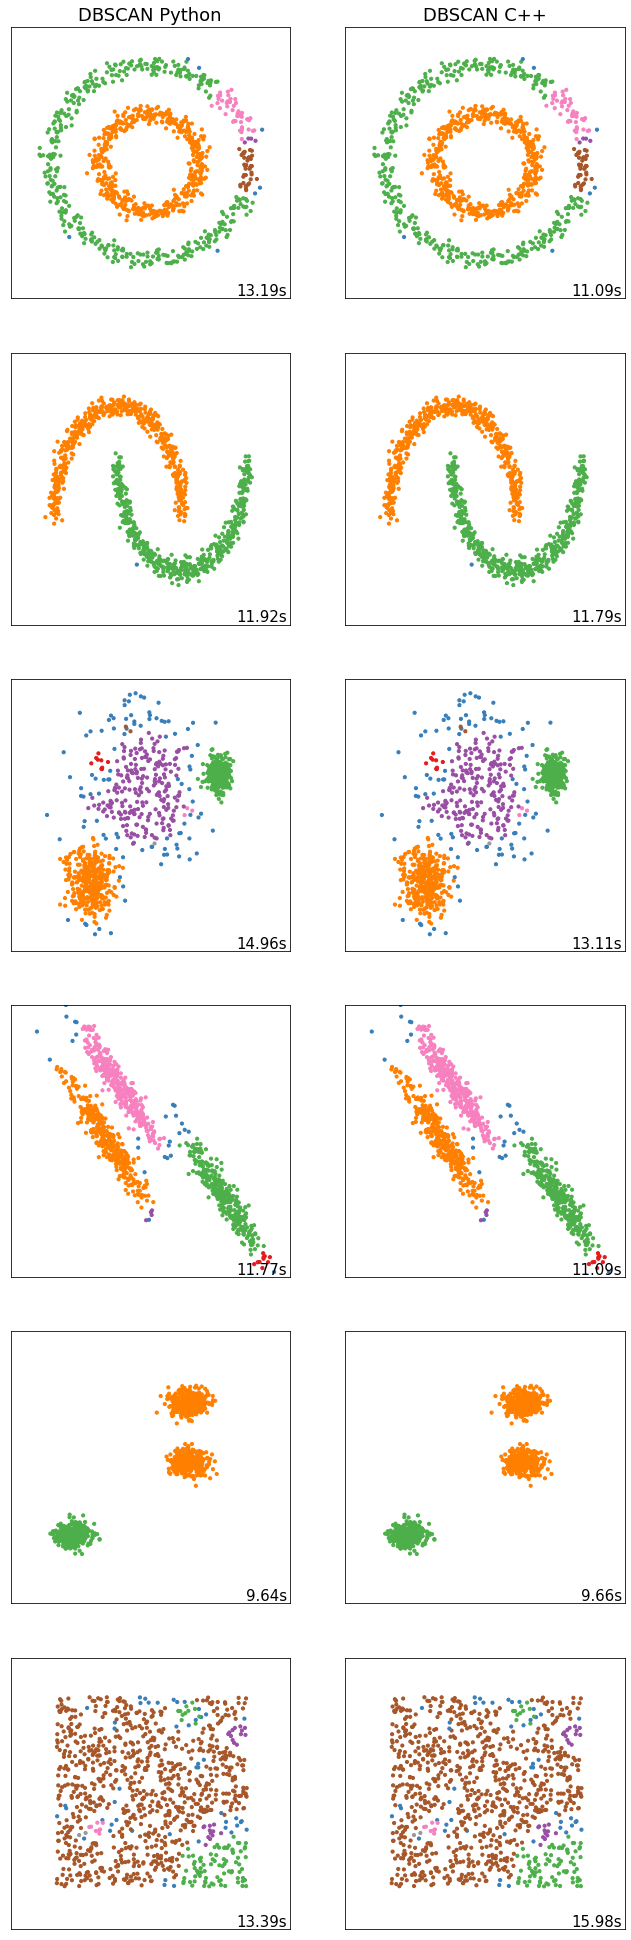

In [86]:
plt.figure(figsize=(11, 35))

plot_num = 1

default_base = {
    "epsilon": 0.3,
    "minPts": 20,
}

datasets = [
    (
        noisy_circles,
        {
            "epsilon": 0.15,
            "minPts": 5,
        },
    ),
    (
        noisy_moons, 
        {
            "epsilon": 0.15,
            "minPts": 5,
        }),
    (
        varied,
        {
            "epsilon": 0.15,
            "minPts": 5,
        },
    ),
    (
        aniso,
        {
            "epsilon": 0.15,
            "minPts": 5,
        },
    ),
    (
        blobs, 
        {            
            "epsilon": 0.65,
            "minPts": 20,
        }
    ),
    (
        no_structure, 
     {
            "epsilon": 0.15,
            "minPts": 5,
     }
    ),
]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    
    if algo_params:
        epsilon = algo_params['epsilon']
        minPts = algo_params['minPts']
    else: 
        epsilon = default_base['epsilon']
        minPts = default_base['minPts']
        
    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)
    
    clustering_algorithms = (
        ("DBSCAN Python", dbscan),
        ("DBSCAN C++", dbscan),
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()
        # print(epsilon, minPts)
        y_pred = dbscan(X, epsilon, minPts)
        t1 = time.time()

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(
            list(
                islice(
                    cycle(
                        [
                            "#377eb8",
                            "#ff7f00",
                            "#4daf4a",
                            "#f781bf",
                            "#a65628",
                            "#984ea3",
                            "#999999",
                            "#e41a1c",
                            "#dede00",
                        ]
                    ),
                    int(max(y_pred) + 1),
                )
            )
        )
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred.astype(int)])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="right",
        )
        plot_num += 1

plt.show()

In [ ]:
|